# NetLogo calibration with NL4Py and DEAP

In this example we use the DEAP library in combination with NL4Py to calibrate the Wolf Sheep Predation model using a simple evolutionary algorithm provided by DEAP. Additionally, both DEAP and NL4Py are parallelized, with DEAP EA individuals executing on a thread pool using multiprocessing library and NL4Py NetLogo HeadlessWorkspaces running on Java threads on the NetLogoControllerServer.

In this experiment, we calibrate the model to find the best parameter configuration able to produce a near-equilibrium state over the first 1000 simulation ticks of the Wolf Sheep Predation model. In other words, the parameters that cause the populations of both wolves and sheep to vary as little as possilbe over the simulation run. 

In [1]:
#!pip install --upgrade --no-cache-dir nl4py

import random
import sys
import time
import os
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt

from deap import base, creator, tools, algorithms

import nl4py

netlogo_path = "C:/Program Files/NetLogo 6.0.4/"
model_path = "Models/Wolf Sheep Predation.nlogo"
nl4py.initialize(netlogo_path)

We will define what a genome of the GA used for calibration is by using NL4Py to read the parameter names and ranges and register this information into a DEAP toolbox.

In [2]:
# In this experiment we intend to maximize fitness. Fitness is the measure of population stability, 
# an indicator of equilibrium in the Wolf Sheep Predation model.
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# An EA Individual is essentially a list of paramter values for our calibration purposes. Through 
# calibration, we intend to find the Individual that produces the highest fitness, or the most
# stable population dynamics.
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
# Use nl4py to find the parameter names and ranges
# Create a HeadlessWorkspace to read in the parameter names and ranges.
n = nl4py.create_headless_workspace()
# Open the model
model_path = "Wolf Sheep Predation.nlogo"
n.open_model(model_path)
# Get the parameter names and ranges.
parameter_names = n.get_param_names()
parameterRanges = n.get_param_ranges()
parameterInitializers = []
# Iterate over the names and ranges and create DEAP initializers for all the parameters of the model
for parameterName, parameterRange in zip(parameter_names, parameterRanges):
    parameterName = ''.join(filter(str.isalnum, str(parameterName)))
    if len(parameterRange) == 3:
        if __name__=="__main__":
            print("Search Space: ")
            print(f'{parameterName} \t\t\t\t min: {str(parameterRange[0])} max: {str(parameterRange[2])} step: {str(parameterRange[1])}')
        toolbox.register(parameterName, random.randrange, parameterRange[0], parameterRange[2], 
            parameterRange[1])
        parameterInitializers.append(eval("toolbox."+str(parameterName)))

# Define the EA "individual" function in the DEAP toolbox which creates an Individual with a list of 
# parameters within the range specified by the NetLogo model interface.
toolbox.register("individual", tools.initCycle, creator.Individual, tuple(parameterInitializers))
# Define the "population" function in the DEAP toolbox
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Define hyperparameters of the evolutionary algorithm
toolbox.register("mate", tools.cxTwoPoint)
lowerBounds = [row[1] for row in parameterRanges[:-2]]
upperBounds = [row[2] for row in parameterRanges[:-2]]
toolbox.register("mutate", tools.mutUniformInt, low = lowerBounds, up = upperBounds, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)


Search Space: 
initialnumbersheep 				 min: 0.0 max: 250.0 step: 1.0
Search Space: 
sheepgainfromfood 				 min: 0.0 max: 50.0 step: 1.0
Search Space: 
sheepreproduce 				 min: 1.0 max: 20.0 step: 1.0
Search Space: 
initialnumberwolves 				 min: 0.0 max: 250.0 step: 1.0
Search Space: 
wolfgainfromfood 				 min: 0.0 max: 100.0 step: 1.0
Search Space: 
wolfreproduce 				 min: 0.0 max: 20.0 step: 1.0
Search Space: 
grassregrowthtime 				 min: 0.0 max: 100.0 step: 1.0


Next, we define a simulation run. This involves:
1. starting a NetLogoHeadlessWorkspace through NL4Py, 
2. opening the Wolf Sheep Predation model, 
3. setting the parameters to the values of the EA individual, 
4. running the simulation
5. calculating the metric 
We setup Headless Workspaces for each EA individual. The HeadlessWorkspaces are reusable per population and are tracked as to when they are free to run another model evaluation

In [3]:
free_workspaces = []
for i in range(0,multiprocessing.cpu_count()):
    n = nl4py.create_headless_workspace()
    n.open_model('Wolf Sheep Predation.nlogo')
    free_workspaces.append(n)

def evaluate_wolf_sheep_predation(individual):
    '''
    The EA individual evaluation is defined as a simulation run of the model for the parameter values 
    specified and reports the total stability metric of the population.
    
    '''
    workspace = free_workspaces[0]
    free_workspaces.remove(workspace)
    for name, value in zip(parameter_names, individual):
        cmd = 'set {0} {1}'.format(name, value)
        workspace.command(cmd)
    workspace.command('set model-version "sheep-wolves-grass"')
    workspace.command('setup')
    simulation_results = workspace.schedule_reporters(["ticks",'count sheep','count wolves'], 0,1,500,"go") 
    free_workspaces.append(workspace)
    aggregate_metric = calculate_population_stability(simulation_results)
    return aggregate_metric,

toolbox.register("evaluate", evaluate_wolf_sheep_predation)

We define the metric as the stability of the population counts of the two species, without either going into extinction. for this we use first order derivatives per simulation time step and a heavy side function to score extinction as 0. High scores indicate more stable populations (closer to complete equilibrium). Please see the Sensitivity analysis Jupyter notebook for a mode detailed description of this calculation.

In [4]:
def calculate_population_stability(simulation_results):
    df = pd.DataFrame(simulation_results)
    sheep_pop = pd.to_numeric(df.iloc[:,1])
    wolves_pop = pd.to_numeric(df.iloc[:,2])
    #since time is in simulation ticks, this is the absolute rate of change of sheep population.
    dsheep_dt = sheep_pop.diff().abs()
    #since time is in simulation ticks, this is the absolute rate of change of wolf population.
    dwolves_dt = wolves_pop.diff().abs()   
    #Find population stabilities over time for species as reciprocal of derivatives multiplied by
    # a heavyside function ensuring extinction is scored at 0.
    epsilon = 0.000001
    population_stability_sheep = np.divide(1,(dsheep_dt + epsilon)).mul(np.where(sheep_pop==0,0,1))
    population_stability_wolves = np.divide(1,(dwolves_dt + epsilon)).mul(np.where(wolves_pop==0,0,1))
    #Find total population stability over time as the mean of population stabilities for both species.
    population_stability_total = (population_stability_sheep + population_stability_wolves) / 2
    #the aggregate metric is the mean, total population stability over time
    aggregate_metric = population_stability_total.sum()/len(population_stability_total)
    return aggregate_metric


We now define the statistics we are interested in tracking and run the EA with custom hyperparameters.

In [5]:
stats = tools.Statistics(key = lambda ind: ind.fitness.values)
stats.register("max",np.max)
stats.register("mean",np.mean)
hof = tools.HallOfFame(1)
POP = 50

In [6]:
import multiprocessing
from multiprocessing.pool import ThreadPool
pool = ThreadPool(multiprocessing.cpu_count())
toolbox.register("map", pool.map)
final_pop, log= algorithms.eaSimple(toolbox.population(n=POP), toolbox, cxpb=0.8, mutpb=0.2, 
            ngen=100,stats = stats,halloffame = hof)

print("The best individual over the complete calibration:")
print(parameter_names)
print(hof)

gen	nevals	max   	mean   
0  	50    	651000	84760.1
1  	45    	516000	137180 
2  	45    	628000	167640 
3  	38    	628000	277300 
4  	43    	588000	369960 
5  	39    	629000	443640 
6  	43    	612000	490780 
7  	40    	678000	486600 
8  	46    	740000	538800 
9  	38    	740000	576580 
10 	42    	814000	637580 
11 	37    	789000	630200 
12 	44    	787000	650780 
13 	35    	821000	690020 
14 	42    	829000	728260 
15 	45    	817000	727140 
16 	44    	827000	719000 
17 	41    	827000	739840 
18 	43    	820000	728800 
19 	49    	827000	707960 
20 	40    	827000	725980 
21 	46    	815000	750920 
22 	47    	825000	684740 
23 	39    	823000	742820 
24 	41    	818000	709780 
25 	44    	819000	740880 
26 	48    	822000	730240 
27 	41    	819000	712640 
28 	43    	813000	724720 
29 	42    	827000	714360 
30 	44    	823000	739060 
31 	38    	823000	735960 
32 	38    	823000	741660 
33 	46    	823000	727120 
34 	43    	822000	719620 
35 	43    	823000	735540 
36 	38    	819000	740680 
37 	44    	8

We can now run and visualize the results...

In [7]:
'''
And plot the convergence progress by the EA
'''
app = nl4py.netlogo_app()
app.open_model(model_path)
for name, value in zip(parameter_names, hof[0]):
    app.command('set {0} {1}'.format(name, value))
app.command("setup")
app.command("repeat 1000 [ if (count turtles < 10000) [go] ]")

Text(0, 0.5, 'Fitness')

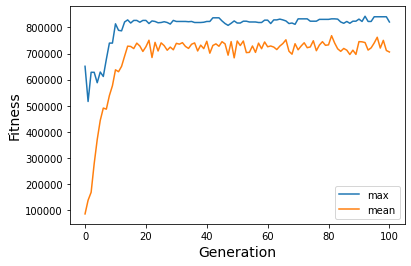

In [8]:
convergence_progress = pd.DataFrame(log)[['max','mean']]
plot = convergence_progress.plot(legend=True)
plt.xlabel("Generation", size = 14)
plt.ylabel("Fitness", size = 14)